# Problem Description

Link: https://fivethirtyeight.com/features/how-hard-is-it-to-find-a-running-buddy/

> Running is more fun when you have someone to run with, but you only want to run with someone if they run about as fast as you do. Perhaps if enough people run together, it becomes more likely that everyone can find a running buddy.

> Let’s say there are $N$ people going for a run, and assume that each person’s preferred running speed, call it $X_i$, is independent and normally distributed, with a mean of $\mu$ and a variance of $\sigma^2$. Or, mathematically,

> $$X_i \sim N(\mu,\sigma^2)$$

>Now, for any given person, let’s assume that the person has a running buddy if there’s another person in the group whose preferred speed is about the same as theirs. Specifically, we’ll say that person $i$ and person $j$ can be running buddies if their preferred speeds are within some number $s$ of each other — that is, if $\lvert X_i−X_j\rvert \leq s$.

>How large does $N$ need to be before the probability of each person having a running buddy is 99 percent? (Assume $\mu$, $\sigma^2$ and $s$ are fixed.)

>Extra credit: Using some data — from a large marathon, perhaps — can you provide some empirical estimates of $\mu, \sigma^2$ and $s$?

# Solution (Single Runner Perspective)

I will assume the goal is to find an $N$ such that each individual has a 99% chance of finding a buddy (as opposed to a 99% chance that every one has a buddy at the conclusion of some matching process).

WLOG, consider runner 1. The probability that runner 1 has no match is:

$$f(N \vert \mu, \sigma^2, s) =P(\lvert X_1 - X_2 \rvert > s, \ldots, \lvert X_1 - X_N \rvert > s) $$

By the independence assumption

$$f(N \vert \mu, \sigma^2, s) = \prod_{i = 2}^N P(\lvert X_1 - X_i \rvert > s) $$

The probability that runner 1 and runner $i$ do not match is:

$$ P(\lvert X_1 - X_i \rvert > s) = P(X_1 - X_i > s) + P(X_1 - X_i < -s) $$

Given the distributional assumptions, $X_1 - X_i \sim N(0,2\sigma^2)$. Since the normal distribution is symmetric, $P(X_1 - X_i > s) = P(X_1 - X_i < -s)$. Therefore

$$P(\lvert X_1 - X_i \rvert > s) = 2\Phi\left(\frac{-s}{\sqrt{2\sigma^2}}\right) $$
where $\Phi(\cdot)$ is the CDF of the unit normal distribution. This leads to the following expression for $f$:

$$ f(N \vert \mu, \sigma^2, s) = \left(2\Phi\left(\frac{-s}{\sqrt{2\sigma^2}}\right)\right)^{N-1} $$

In order for runner 1 to find a buddy with probability $\rho \in [0,1]$, we need $f(N \vert \mu, \sigma^2, s) = 1-\rho$. Taking logs we can solve for $N$:

$$ N = 1 + \frac{\log(1-\rho)}{\log\left(2\Phi\left(\frac{-s}{\sqrt{2\sigma^2}}\right)\right)} $$

A few things we can note about this expression:

* $N$ is independent of $\mu$ since the only relevant quantity for finding a match is the *relative* speed of the runners
* $N$ is decreasing in $s$; as runners become more tolerant of differences in speed, it is easier to find a match
* $N$ is increasing in $\sigma^2$; if runner speed is widely dispersed, it's harder to find a match
* $N$ is increasing in $\rho$;  we need more runners if we want to be more certain of finding a match

In [1]:
import numpy as np
from scipy import stats
from scipy.optimize import root
import matplotlib.pyplot as plt

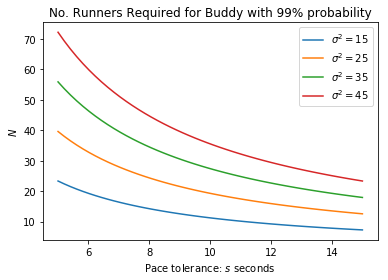

In [2]:
def N(rho, s, sigma):
    #No. runners needed to find a buddy with probability rho: see above
    num, denom = np.log(1-rho), np.log(2*stats.norm.cdf(-s/(np.sqrt(2)*sigma)))
    return 1 + num/denom

def plot(rho = 0.99, s_min = 5, s_max = 15, sig_min = 15, sig_max = 45, sig_length = 4):
    #Plots N() for a range of s and sigma values
    s_range = np.linspace(s_min,s_max)
    sigma_range = np.linspace(sig_min,sig_max,sig_length)
    for sig in sigma_range:
        plt.plot(s_range,N(rho, s_range, sig), label = '$\sigma^2 = $%s'%(int(sig)))
    plt.title('No. Runners Required for Buddy with %s%s probability' %(int(100*rho),'%'))
    plt.xlabel('Pace tolerance: $s$ seconds')
    plt.ylabel('$N$')
    plt.legend()
    plt.show()
    
plot()

# Solution (Group Perspective)

If we instead require a 99% probability that every member of the group has a match, this problem becomes more complicated since matches aren't independent. In addition, by increasing the number of runners we also increase the number of required matches, so it's not *a priori* clear we can achieve arbitrarily high levels of $\rho$.

As an example, consider the case with three runners, $i,j$ and $k$, and write $P(i)$ as the probability that runner $i$ matches. We can decompose the probability that all runners match as:

$$P(i, j, k) = P(i)P(j \vert i) P(k \vert i, j)$$

The probability that $j$ matches given that $i$ matches is not the same as the unconditional probability $P(j)$, since half the time $i$ will have matched with $j$.

Since I prefer to avoid hard problems, consider the case when $N$ is large. In that case, the distribution of the matched runners will approximate the overall distribution, and so matches should be nearly independent for $N$ large. This gives the approximation:

$$P(\text{all match}) \approx P(1)^N = \left(1 - \zeta^{N-1}\right)^N $$
where $\zeta \equiv 2\Phi\left(\frac{-s}{\sqrt{2\sigma^2}}\right)$. Taking logs:

$$\log(\rho) = N\log\left(1 - \zeta^{N-1}\right)$$

This equation doesn't have a closed-form solution, but we can find a solution numerically with relative ease. Below I plot the solution for a range of $s$ values. As we would expect, it takes more runners to ensure everyone in the group is likely to have a match.

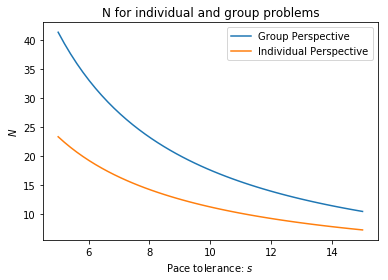

In [4]:
def plot2(rho = .99, sigma = 15, s_min = 5, s_max = 15):
    def f(n):
        zeta = 2*stats.norm.cdf(-s/(np.sqrt(2)*sigma))
        return np.log(rho) - n*np.log(1-zeta**(n-1))
    s_vec = np.linspace(s_min,s_max)
    n_group = []
    for s in s_vec:
        n_group.append(root(f,10).x)
    plt.plot(s_vec,n_group, label = 'Group Perspective')
    plt.plot(s_vec, N(.99,s_vec,15), label = 'Individual Perspective')
    plt.legend()
    plt.title('N for individual and group problems')
    plt.xlabel('Pace tolerance: $s$')
    plt.ylabel('$N$')
    plt.show()
    
plot2()